# Greater than the sum of its parts?

*How does the aggregate model compare to the best individual classification?*

In this notebook we will optimized both the aggregate model for a galaxy, as well as its best individual classification. We'll then compare the residuals and mean squared errors of the two, and see how they stack up!

**Warning:** The fitting step here takes a long time (~15 minutes) to complete. Which sucks.

First, define some useful magic commands and import needed modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import lib.galaxy_utilities as gu
import lib.python_model_renderer.parse_annotation as pa
import lib.python_model_renderer.render_galaxy as rg
from model_fitting import Model, ModelFitter
from sklearn.metrics import mean_squared_error

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

Define the subject id of the galaxy we'll be working on

In [3]:
subject_id = 20902040

Load all the required metadata for plotting etc...

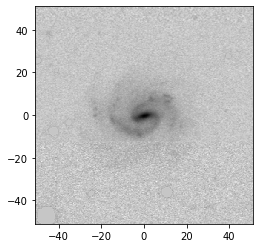

In [4]:
gal, angle = gu.get_galaxy_and_angle(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
psf = gu.get_psf(subject_id)
diff_data = gu.get_image_data(subject_id)
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
galaxy_data = np.array(diff_data['imageData'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']
# arcseconds per pixel for zooniverse image
pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)
# arcseconds per pixel for galaxy data
pix_size2 = galaxy_data.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)

imshow_kwargs = {
    'cmap': 'gray_r', 'origin': 'lower',
    'extent': (
        # left of image in arcseconds from centre
        -pic_array.shape[0]/2 / pix_size,
        pic_array.shape[0]/2 / pix_size,  # right...
        -pic_array.shape[1]/2 / pix_size,  # bottom...
        pic_array.shape[1]/2 / pix_size  # top...
    ),
}
plt.imshow(pic_array, **imshow_kwargs)

Grab the aggregate model

In [5]:
with open(
    '../component-clustering/cluster-output/{}.json'.format(subject_id)
) as f:
    aggregate_model = json.load(f)

agg_model = pa.parse_aggregate_model(aggregate_model, size_diff=size_diff)

And the best individual classification

In [6]:
with open('lib/best-classifications.json') as f:
  all_best_cls = json.load(f)
best_cls = gu.classifications[
    gu.classifications.classification_id == all_best_cls.get(str(subject_id))
].iloc[0]
best_model = pa.parse_annotation(json.loads(best_cls['annotations']), size_diff)

Define a helper function that will perform the model optimization

In [7]:
def fit_model(model, n=100):
    m = deepcopy(model)
    m['spiral'] = []
    mf = ModelFitter(m, galaxy_data, psf, pixel_mask)
    new_model, res = mf.fit(options={'maxiter': n})
    print('{}, {}, N steps: {}'.format(res['success'], str(res['message']), res['nit']))
    return new_model

Perform the optimization, warning: this takes a while.

In [8]:
%time fitted_best_model = fit_model(best_model)
%time fitted_agg_model = fit_model(agg_model)

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', N steps: 34
CPU times: user 2min 16s, sys: 4.56 s, total: 2min 21s
Wall time: 2min 21s


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Define a helper function that will do the post-processing of the models for plotting

In [9]:
conv = lambda arr: rg.convolve2d(arr, psf, mode='same', boundary='symm')

Calculate the rendered models and residuals to be plotted

In [10]:
fitted_best_rendered = rg.calculate_model(fitted_best_model, diff_data['width'])
fitted_agg_rendered = rg.calculate_model(fitted_agg_model, diff_data['width'])

fitted_best_comparison = rg.compare_to_galaxy(fitted_best_rendered, psf, galaxy_data, pixel_mask=pixel_mask, stretch=False)
fitted_agg_comparison = rg.compare_to_galaxy(fitted_agg_rendered, psf, galaxy_data, pixel_mask=pixel_mask, stretch=False)

NameError: name 'fitted_agg_model' is not defined

Grab a value to use for limits on the residuals plot

In [11]:
l = max(fitted_best_comparison.max(), fitted_agg_comparison.max())

NameError: name 'fitted_best_comparison' is not defined

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
def make_suptitle(arr, pre=None):
    s = mean_squared_error(0.8 * galaxy_data, arr)
    plt.suptitle((pre + ' ' if pre else '') + 'Mean Squared Error: {:.8f}'.format(s))

NameError: name 'fitted_best_comparison' is not defined

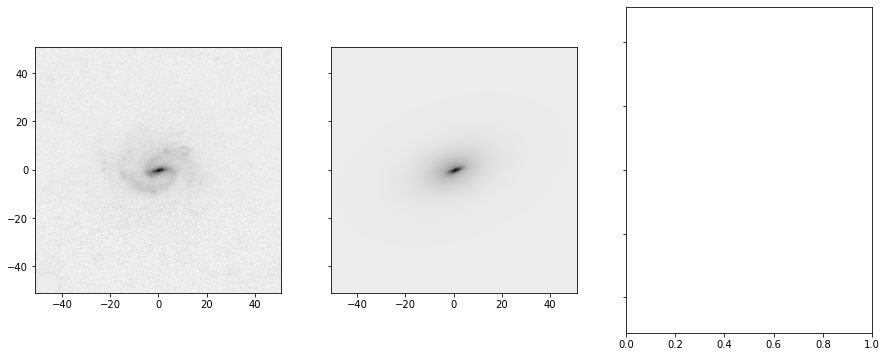

In [14]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 6))
ax[0].imshow(0.8 * galaxy_data, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[1].imshow(conv(fitted_best_rendered), **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[2].imshow(
    fitted_best_comparison,
    **{**imshow_kwargs, 'cmap': 'RdGy'},
    vmin=-l, vmax=l
)
make_suptitle(fitted_best_comparison, 'Best individual model:')
plt.tight_layout()

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 6))
ax[0].imshow(0.8 * galaxy_data, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[1].imshow(conv(fitted_agg_rendered), **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[2].imshow(
    fitted_agg_comparison,
    **{**imshow_kwargs, 'cmap': 'RdGy'},
    vmin=-l, vmax=l
)
make_suptitle(fitted_agg_comparison, 'Aggregate model:')
plt.tight_layout();

NameError: name 'fitted_agg_rendered' is not defined

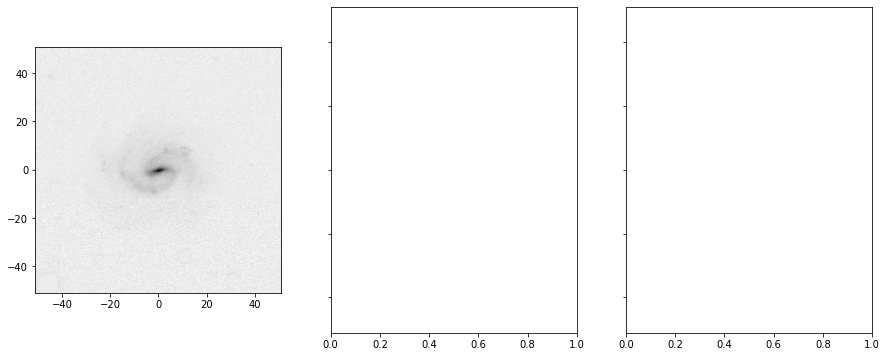

In [15]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 6))
ax[0].imshow(0.8 * galaxy_data, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[1].imshow(conv(fitted_agg_rendered), **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[2].imshow(
    fitted_agg_comparison,
    **{**imshow_kwargs, 'cmap': 'RdGy'},
    vmin=-l, vmax=l
)
make_suptitle(fitted_agg_comparison)
plt.tight_layout();

In [16]:
Model(fitted_best_model, galaxy_data, psf, pixel_mask)

In [17]:
Model(fitted_agg_model, galaxy_data, psf, pixel_mask)

NameError: name 'fitted_agg_model' is not defined